In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import preprocessing

In [2]:
# import data
train = pd.read_csv("../input/train.csv").set_index('id')
test = pd.read_csv("../input/test.csv").set_index('id')
loc_fix = pd.read_excel(open("../input/BAD_ADDRESS_FIX.xlsx","rb"), sheetname='BAD').drop_duplicates('id').set_index('id')
print('Training data: ',train.shape)
print('Test data: ',test.shape)
print('Address fix: ',loc_fix.shape)

# import lat, lon data
latlon_train = pd.read_csv("../sberbankmoscowroads/train_lat_lon.csv").set_index('id')
latlon_test = pd.read_csv("../sberbankmoscowroads/test_lat_lon.csv").set_index('id')

# remove 'key' and 'tolerance_m' columns
latlon_train = latlon_train.drop('key',1)
latlon_test = latlon_test.drop('key',1)
latlon_train = latlon_train.drop('tolerance_m',1)
latlon_test = latlon_test.drop('tolerance_m',1)

# import macro data
macro = pd.read_csv("../input/macro.csv")

Training data:  (30471, 291)
Test data:  (7662, 290)
Address fix:  (699, 279)


## Address fix and lat/lon coordinates

In [3]:
# first address fix
print('Number of bad entries in training set: ', len(set(train[train.kremlin_km == train.kremlin_km.min()].index)))
train.update(loc_fix)
test.update(loc_fix)
print('Fix in train: ', train.index.intersection(loc_fix.index).shape[0])
print('Fix in test : ', test.index.intersection(loc_fix.index).shape[0])

# drop entries that haven't been fixed
nument_before = train.shape[0]
bad_train_indexset = set(train[train.kremlin_km == train.kremlin_km.min()].index)
train.drop(bad_train_indexset, inplace=True)
nument_after = train.shape[0]
print('Dropped ', nument_before-nument_after, ' entries from training set.')

# add lat/lon
train['lat'] = np.NaN
train['lon'] = np.NaN
test['lat'] = np.NaN
test['lon'] = np.NaN
train.update(latlon_train)
test.update(latlon_test)

Number of bad entries in training set:  603
Fix in train:  550
Fix in test :  149
Dropped  53  entries from training set.


In [4]:
# view the dataframe
pd.set_option('display.max_columns', None)
train.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

## Concatenate training and test sets for cleaning

In [5]:
test['price_doc'] = np.NaN
test['testdata'] = True
train['testdata'] = False

data_all = pd.concat([train,test])

In [6]:
# get features from timestamp
data_all['time_year'] = data_all['timestamp']
data_all['time_month'] = data_all['timestamp']
data_all['time_day'] = data_all['timestamp']
data_all['time_year'] = data_all['time_year'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
data_all['time_month'] = data_all['time_month'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
data_all['time_day'] = data_all['time_day'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)

# get number of days from first sale
first_sale = data_all['timestamp'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).min()
print(first_sale.year, first_sale.month, first_sale.day)
data_all['days_after_first'] = data_all['timestamp']
data_all['days_after_first'] = data_all['days_after_first'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d')-first_sale).days)

2011 8 20


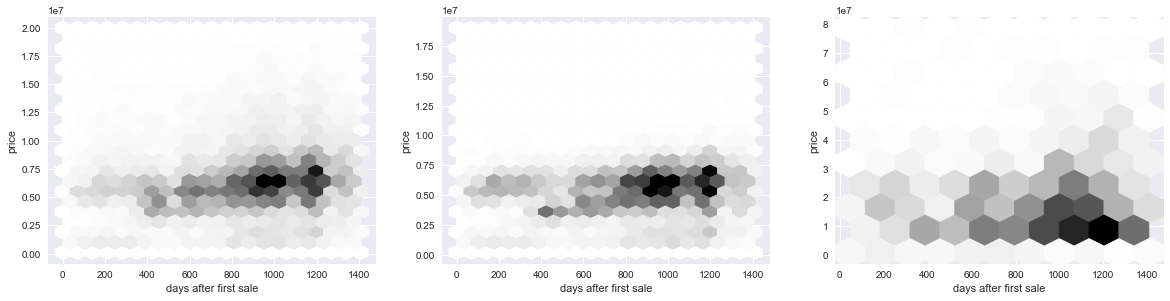

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(20,10)

indx = data_all.price_doc < 20000000
plt.subplot(2,3,1)
plt.hexbin(data_all[indx].days_after_first, data_all[indx].price_doc, gridsize=20)
plt.xlabel('days after first sale')
plt.ylabel('price')

indx = (data_all.price_doc < 20000000) & (data_all.full_sq < 50)
plt.subplot(2,3,2)
plt.hexbin(data_all[indx].days_after_first, data_all[indx].price_doc, gridsize=20)
plt.xlabel('days after first sale')
plt.ylabel('price')

indx = (data_all.price_doc < 80000000) & (data_all.full_sq > 100)
plt.subplot(2,3,3)
plt.hexbin(data_all[indx].days_after_first, data_all[indx].price_doc, gridsize=10)
plt.xlabel('days after first sale')
plt.ylabel('price')
plt.show()

## Get forex data for each date

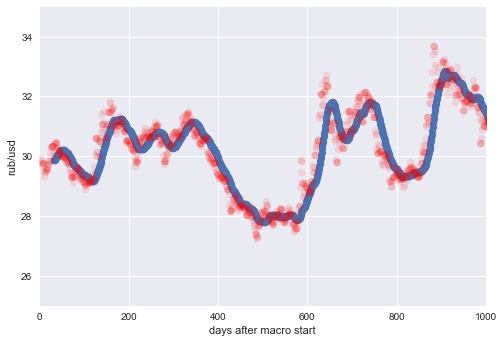

In [8]:
# beginning of macro data is at index=0
macro_start = macro['timestamp'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d')).min()

# convert daily values into monthly
#macro['months_after_start'] = macro['timestamp']
macro['months_after_start'] = macro['timestamp'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d').year-macro_start.year)*12 + (datetime.strptime(x, '%Y-%m-%d').month-macro_start.month))
macro['usdrub_monthly'] = np.NaN
macro['eurrub_monthly'] = np.NaN
macro['brent_monthly'] = np.NaN
max_months = macro['months_after_start'].max()
for m in range(max_months+1):
    idx = (macro['months_after_start'] == m)
    macro.loc[idx, 'usdrub_monthly'] = macro[idx].usdrub.mean()
    macro.loc[idx,'eurrub_monthly'] = macro[idx].eurrub.mean()
    macro.loc[idx,'brent_monthly'] = macro[idx].brent.mean()

# try rolling average
# setting the value to the right-side edge of rolling mean
macro['usdrub_rolling'] = macro['usdrub']
macro['eurrub_rolling'] = macro['eurrub']
macro['brent_rolling'] = macro['brent']
macro['usdrub_rolling'] = macro['usdrub_rolling'].rolling(window=30,center=False).mean()
macro['eurrub_rolling'] = macro['eurrub_rolling'].rolling(window=30,center=False).mean()
macro['brent_rolling'] = macro['brent_rolling'].rolling(window=30,center=False).mean()

data_all['usdrub'] = np.NaN
data_all['eurrub'] = np.NaN
data_all['brent'] = np.NaN

for i, row in data_all.iterrows():
    data_all.set_value(i, 'usdrub', macro.loc[(datetime.strptime(row['timestamp'],'%Y-%m-%d')-macro_start).days,'usdrub_rolling'])
    data_all.set_value(i, 'eurrub', macro.loc[(datetime.strptime(row['timestamp'],'%Y-%m-%d')-macro_start).days,'eurrub_rolling'])
    data_all.set_value(i, 'brent', macro.loc[(datetime.strptime(row['timestamp'],'%Y-%m-%d')-macro_start).days,'brent_rolling'])

#print(first_sale-macro_start)
#print(first_sale, macro.loc[(first_sale-macro_start).days,'timestamp'])
plt.figure()
plt.scatter(macro['timestamp'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d')-macro_start).days), macro['usdrub_rolling'])
plt.scatter(macro['timestamp'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d')-macro_start).days), macro['usdrub'], color='red', alpha=0.1)
plt.xlim(0,1000)
plt.ylim(25,35)
plt.xlabel('days after macro start')
plt.ylabel('rub/usd')
plt.show()

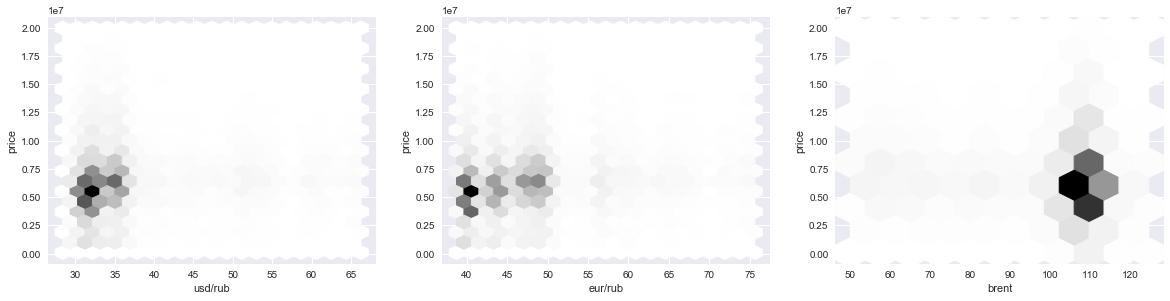

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(20,10)

indx = data_all.price_doc < 20000000
plt.subplot(2,3,1)
plt.hexbin(data_all[indx].usdrub, data_all[indx].price_doc, gridsize=20)
plt.xlabel('usd/rub')
plt.ylabel('price')

indx = data_all.price_doc < 20000000
plt.subplot(2,3,2)
plt.hexbin(data_all[indx].eurrub, data_all[indx].price_doc, gridsize=20)
plt.xlabel('eur/rub')
plt.ylabel('price')

indx = data_all.price_doc < 20000000
plt.subplot(2,3,3)
plt.hexbin(data_all[indx].brent, data_all[indx].price_doc, gridsize=10)
plt.xlabel('brent')
plt.ylabel('price')
plt.show()

## Fill in missing values

In [10]:
# for max_floor > 47 and max_floor == 0, set to NaN
# (the tallest building in Moscow is 47 floors)
data_all.loc[data_all['max_floor'] > 47, 'max_floor'] = np.NaN
data_all.loc[data_all['max_floor'] == 0, 'max_floor'] = np.NaN

# for max_floor < floor, set to NaN
data_all.loc[data_all['max_floor'] < data_all['floor'], 'max_floor'] = np.NaN

# fix anomalous build_year
data_all.loc[data_all['build_year'] == 1691, 'build_year'] = 1961
data_all.loc[data_all['build_year'] == 215, 'build_year'] = 2015
data_all.loc[data_all['build_year'] == 4965, 'build_year'] = 1965
data_all.loc[data_all['build_year'] == 2, 'build_year'] = 2014
data_all.loc[data_all['build_year'] == 3, 'build_year'] = 2013 #1960
data_all.loc[data_all['build_year'] == 20, 'build_year'] = 2014
data_all.loc[data_all['build_year'] == 20052009, 'build_year'] = 2009
data_all.loc[data_all['build_year'] == 0, 'build_year'] = np.NaN
data_all.loc[data_all['build_year'] == 1, 'build_year'] = np.NaN
data_all.loc[data_all['build_year'] == 71, 'build_year'] = np.NaN

# quick fix for anomalous full_sq
data_all.loc[data_all['full_sq'] > 1000, 'full_sq'] = data_all['full_sq']/100
data_all.loc[data_all['full_sq'] > 250, 'full_sq'] = data_all['full_sq']/10
data_all.loc[data_all['full_sq'] < 25, 'full_sq'] = np.NaN

# do the same with life_sq
data_all.loc[data_all['life_sq'] > 1000, 'life_sq'] = data_all['life_sq']/100
data_all.loc[data_all['life_sq'] > 250, 'life_sq'] = data_all['life_sq']/10
data_all.loc[data_all['life_sq'] < 10, 'life_sq'] = np.NaN

# if life_sq > full_sq, set to NaN
data_all.loc[data_all['life_sq'] > data_all['full_sq'], 'life_sq'] = np.NaN

# if full_sq - life_sq < 8, set to NaN
data_all.loc[data_all['life_sq'] > data_all['full_sq'] - 8, 'life_sq'] = np.NaN

In [11]:
# fill in missing full_sq, life_sq, kitch_sq
# using simple linear regressions
for i, row in data_all.iterrows():
    if np.isnan(row['full_sq']) & np.isfinite(row['life_sq']) & np.isfinite(row['kitch_sq']):
        data_all.set_value(i, 'full_sq', 1.15 + 1.33*(row['life_sq']+row['kitch_sq']) )
    if np.isnan(row['life_sq']) & np.isfinite(row['full_sq']) & np.isfinite(row['kitch_sq']):
        data_all.set_value(i, 'life_sq', (row['full_sq']-1.15)/1.33 - row['kitch_sq'] )
    if np.isnan(row['kitch_sq']) & np.isfinite(row['full_sq']) & np.isfinite(row['life_sq']):
        data_all.set_value(i, 'kitch_sq', (row['full_sq']-1.15)/1.33 - row['life_sq'] )
    if np.isnan(row['full_sq']) & np.isfinite(row['life_sq']) & np.isnan(row['kitch_sq']):
        data_all.set_value(i, 'full_sq', 9.27 + 1.41*(row['life_sq']) )
    if np.isnan(row['life_sq']) & np.isfinite(row['full_sq']) & np.isnan(row['kitch_sq']):
        data_all.set_value(i, 'life_sq', (row['full_sq']-9.27)/1.41 )

In [12]:
# drop extreme values of price_doc/full_sq
# these filters increase the rmse, not sure they are good...
data_all = data_all[ (data_all['price_doc']/data_all['full_sq'] < 1e6)  | (data_all['testdata'] == True) ]
data_all = data_all[ (data_all['full_sq'] >= 25) | (data_all['full_sq'] == np.NaN) | (data_all['testdata'] == True) ]

## Numerical and Categorical features

In [13]:
# save price_doc column from training set
y = data_all[ data_all['testdata'] == False ].price_doc

# separate numerical and categorical features
categorical_features = data_all.select_dtypes(include = ['object']).columns
categorical_features = categorical_features.drop('timestamp')
numerical_features = data_all.select_dtypes(exclude = ['object']).columns
numerical_features = numerical_features.drop('price_doc')
#numerical_features = numerical_features.drop('days_after_first')
#numerical_features = numerical_features.drop('usdrub')
#numerical_features = numerical_features.drop('eurrub')
#numerical_features = numerical_features.drop('brent')
numerical_features = numerical_features.drop('time_day')
numerical_features = numerical_features.drop('lat')
numerical_features = numerical_features.drop('lon')

print('Numerical features : ' + str(len(numerical_features)))
print('Categorical features : ' + str(len(categorical_features)))
data_num = data_all[numerical_features]
data_cat = data_all[categorical_features]

print('List of categorical features:')
print(categorical_features.values)

Numerical features : 281
Categorical features : 15
List of categorical features:
['big_market_raion' 'big_road1_1line' 'culture_objects_top_25'
 'detention_facility_raion' 'ecology' 'incineration_raion'
 'nuclear_reactor_raion' 'oil_chemistry_raion' 'product_type'
 'radiation_raion' 'railroad_1line' 'railroad_terminal_raion' 'sub_area'
 'thermal_power_plant_raion' 'water_1line']


In [14]:
# fill NaN's with the median value for numerical features
print("NaNs (before): " + str(data_num.isnull().values.sum()))
#data_num = data_num.fillna(data_num.median())
print("NaNs (after): " + str(data_num.isnull().values.sum()))

NaNs (before): 297744
NaNs (after): 297744


In [15]:
# create dummy features for categorical values via one-hot encoding
#data_cat = pd.get_dummies(data_cat)

# transform categorical features to integers
for c in data_cat.columns:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(data_cat[c].values))
    data_cat[c] = lbl.transform(list(data_cat[c].values))

/usr/local/lib/python3.4/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
print('Number of numerical features: ', len(data_num.columns))
print('Number of categorical features: ', len(data_cat.columns))

Number of numerical features:  281
Number of categorical features:  15


In [17]:
# join categorical and numerical features
data_all = pd.concat([data_num, data_cat], axis = 1)

# Modeling

In [18]:
# separate training and test data
train = data_all[ data_all['testdata'] == False ]
test = data_all[ data_all['testdata'] == True ]
test.head()

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,16_29_female,16_29_male,7_14_all,7_14_female,7_14_male,ID_big_road1,ID_big_road2,ID_bus_terminal,ID_metro,ID_railroad_station_avto,ID_railroad_station_walk,ID_railroad_terminal,additional_education_km,additional_education_raion,area_m,basketball_km,big_church_count_1000,big_church_count_1500,big_church_count_2000,big_church_count_3000,big_church_count_500,big_church_count_5000,big_church_km,big_market_km,big_road1_km,big_road2_km,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,build_count_before_1920,build_count_block,build_count_brick,build_count_foam,build_count_frame,build_count_mix,build_count_monolith,build_count_panel,build_count_slag,build_count_wood,build_year,bulvar_ring_km,bus_terminal_avto_km,cafe_avg_price_1000,cafe_avg_price_1500,cafe_avg_price_2000,cafe_avg_price_3000,cafe_avg_price_500,cafe_avg_price_5000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_500,cafe_count_1000_price_high,cafe_count_1500,cafe_count_1500_na_price,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_500,cafe_count_1500_price_high,cafe_count_2000,cafe_count_2000_na_price,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_500,cafe_count_2000_price_high,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_500,cafe_count_3000_price_high,cafe_count_500,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_500,cafe_count_5000_price_high,cafe_count_500_na_price,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_500,cafe_count_500_price_high,cafe_sum_1000_max_price_avg,cafe_sum_1000_min_price_avg,cafe_sum_1500_max_price_avg,cafe_sum_1500_min_price_avg,cafe_sum_2000_max_price_avg,cafe_sum_2000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_sum_3000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_sum_5000_min_price_avg,cafe_sum_500_max_price_avg,cafe_sum_500_min_price_avg,catering_km,cemetery_km,children_preschool,children_school,church_count_1000,church_count_1500,church_count_2000,church_count_3000,church_count_500,church_count_5000,church_synagogue_km,culture_objects_top_25_raion,detention_facility_km,ekder_all,ekder_female,ekder_male,exhibition_km,female_f,fitness_km,floor,full_all,full_sq,green_part_1000,green_part_1500,green_part_2000,green_part_3000,green_part_500,green_part_5000,green_zone_km,green_zone_part,healthcare_centers_raion,hospice_morgue_km,hospital_beds_raion,ice_rink_km,incineration_km,indust_part,industrial_km,kindergarten_km,kitch_sq,kremlin_km,leisure_count_1000,leisure_count_1500,leisure_count_2000,leisure_count_3000,leisure_count_500,leisure_count_5000,life_sq,male_f,market_count_1000,market_count_1500,market_count_2000,market_count_3000,market_count_500,market_count_5000,market_shop_km,material,max_floor,metro_km_avto,metro_km_walk,metro_min_avto,metro_min_walk,mkad_km,mosque_count_1000,mosque_count_1500,mosque_count_2000,mosque_count_3000,mosque_count_500,mosque_count_5000,mosque_km,museum_km,nuclear_reactor_km,num_room,office_count_1000,office_count_1500,office_count_2000,office_count_3000,office_count_500,office_count_5000,office_km,office_raion,office_sqm_1000,office_sqm_1500,office_sqm_2000,office_sqm_3000,office_sqm_500,office_sqm_5000,oil_chemistry_km,park_km,power_transmission_line_km,preschool_education_centers_raion,preschool_km,preschool_quota,prom_part_1000,prom_part_1500,prom_part_2000,prom_pa

In [19]:
# take log of price_doc
y = np.log1p(y)

In [20]:
# partition the dataset into train + validation sets
#x_train, x_val, y_train, y_val = train_test_split(train, y, test_size = 0.2, random_state = 1)
#print("x_train : " + str(x_train.shape))
#print("x_val : " + str(x_val.shape))
#print("y_train : " + str(y_train.shape))
#print("y_val : " + str(y_val.shape))

y_train = y#train['price_doc']
x_train = train#.drop('price_doc', axis=1)
x_test = test#.drop('price_doc',axis=1)

## Implement XGBoost

In [27]:
import xgboost as xgb

#xgb_params = {
#    'eta': 0.05,
#    'max_depth': 5,
#    'subsample': 0.7,
#    'colsample_bytree': 0.7,
#    'objective': 'reg:linear',
#    'eval_metric': 'rmse',
#    'silent': 1
#}

#xgb_params = {
#    'eta': 0.05,
#    'max_depth': 3,
#    'subsample': 0.7,
#    'colsample_bytree': 0.7,
#    'objective': 'reg:linear',
#    'eval_metric': 'rmse',
#    'silent': 1,
#    'min_child_weight': 6
#}

xgb_params = {
    'eta': 0.05,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'min_child_weight': 6
}

dtrain = xgb.DMatrix(x_train, y_train)
#dval = xgb.DMatrix(x_val)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
    verbose_eval=50, show_stdv=False, nfold=6)

num_boost_rounds = len(cv_output)
final_rmse = cv_output['test-rmse-mean'].iloc[-1]
print('Boost rounds: ', num_boost_rounds)
print('Final RMSE: ', str('%.5f' % final_rmse))

[0]	train-rmse:14.3684	test-rmse:14.3684
[50]	train-rmse:1.20436	test-rmse:1.20572
[100]	train-rmse:0.468979	test-rmse:0.476041
[150]	train-rmse:0.453337	test-rmse:0.464332
[200]	train-rmse:0.447623	test-rmse:0.4623
[250]	train-rmse:0.442896	test-rmse:0.461217
[300]	train-rmse:0.438897	test-rmse:0.460562
[350]	train-rmse:0.435272	test-rmse:0.46015
[400]	train-rmse:0.431916	test-rmse:0.459753
[450]	train-rmse:0.42864	test-rmse:0.459582
[500]	train-rmse:0.425614	test-rmse:0.459431
[550]	train-rmse:0.422784	test-rmse:0.459372
Boost rounds:  551
Final RMSE:  0.45937


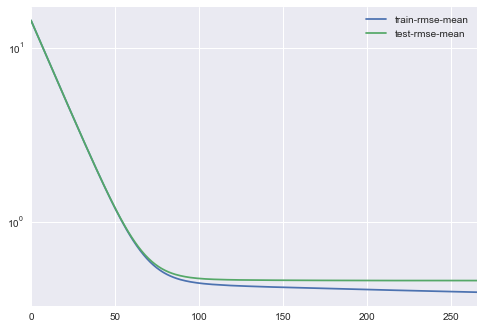

In [22]:
# look at cross validation and boosting
plt.figure()
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
plt.yscale('log')
plt.show()

In [23]:
# choose the best model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

### Feature importance

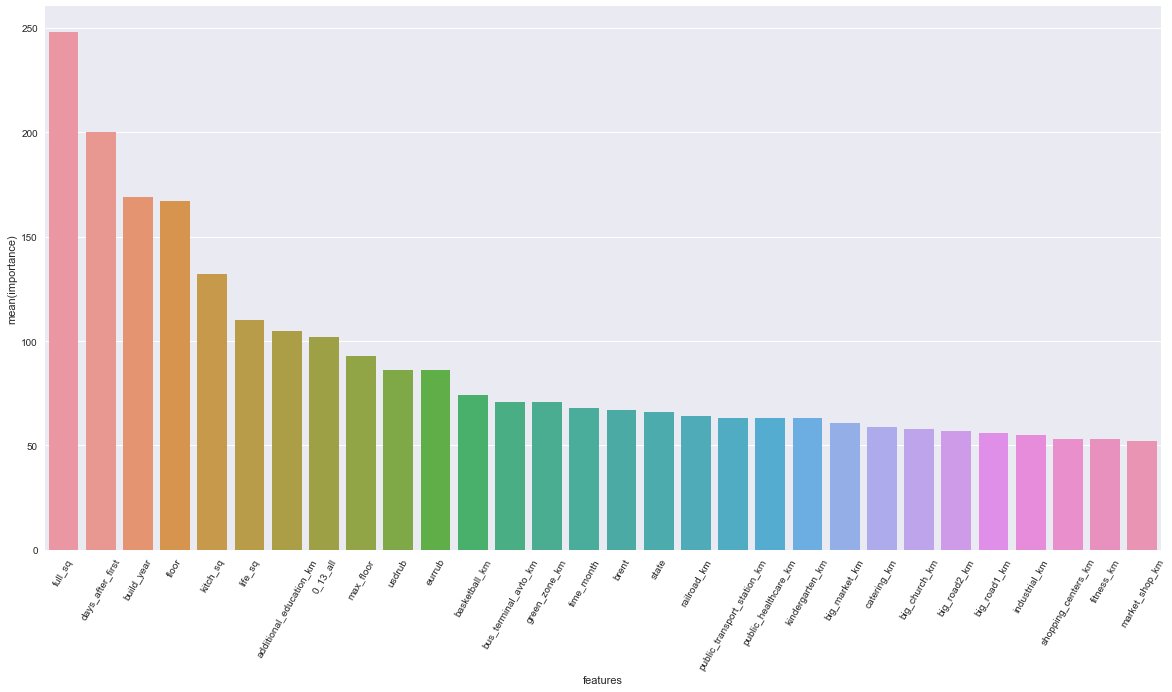

                                  features  importance
247                                full_sq         248
266                       days_after_first         200
256                             build_year         169
118                                  floor         167
145                               kitch_sq         132
240                                life_sq         110
60                 additional_education_km         105
184                               0_13_all         102
259                              max_floor          93
15                                  usdrub          86
3                                   eurrub          86
74                           basketball_km          74
186                   bus_terminal_avto_km          71
114                          green_zone_km          71
270                             time_month          68
2                                    brent          67
120                                  state          66
239       

In [24]:
# look at plot of features
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
plt.figure()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sn.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")
plt.show()
print(features[['features', 'importance']])

## Output results of XGBoost model

In [25]:
# get matrix
dtest = xgb.DMatrix(test)

# compute the results
yres = model.predict(dtest)

result = pd.DataFrame(np.expm1(yres),index=test.index, columns=['price_doc'])
result.index.name = 'id'
print(result.head())

       price_doc
id              
30474  5548225.0
30475  8276203.0
30476  4874343.0
30477  6260070.0
30478  5317414.0


In [26]:
# output to csv
outname = '../results/submission_xgb_' + datetime.now().strftime("%Y%m%d_%H%M") + '_' + str('%.4f' % final_rmse) + '.csv'
result.to_csv(outname)

### Notes on output results

  * Without removing extreme values, best rmse is 0.4576.  Adding filters increases to 0.462.
  * Best rmse occurs with random_state = 1.  Should check for overfitting...
  * Adding days_after_first reduces to 0.4610.
  * Adding macro features slightly increases to 0.4618.
  
 Try playing with gdb params.  Currently, max_depth=5, min_child_weight=1.
   * max_depth=3, min_child_weight=6: rmse = 0.46024
   * Adding back extreme values gives rmse = 0.45648.
 
 In leaderboard, removing extreme values helps 0.328 --> 0.326.